# Hands-On Graph Convolutional Neural Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/gcn.ipynb)

En este notebook implementaremos una red grafal convolucional.

#### Referencias
- [Introduction: Hands-On Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing)
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Hands-On Graph Neural Networks Using Python](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520/ref=sr_1_1?crid=3A0QN1RYH7QQP&dib=eyJ2IjoiMSJ9.-qrnI2P8riRrQ4N6OPe1T9dfnkNhYgbD_-VhWVg_MfGU6D4U1TYZdUeJzAAZ1zhM7oyFoU7g3g3DppC-4DGSfmfmBfPUimLKlEKzBnujFTDHedtcSZuiN9EbIyNLxgkYbwfb0Nq4XhQQQZlS4JYFrBs0-rpkS8EmRz1o2OEJ0qrL9EXU9EJuj9cxCWt7J5HFE4nrJJYOPsX9aI78tp1LAEJqdUW14r9RbOYob9JQK0M.wej4dkKelg8wk6GVu5yxbMuiXefgjxhK-E-2n4_dFBs&dib_tag=se&keywords=hands+on+graph+neural+networks+using+python&qid=1713378267&sprefix=handson+gra%2Caps%2C197&sr=8-1)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [3]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Funciones utilitarias

Primero, definimos unas cuantas funciones utilitarias para visualizar los grafos. Simplemente añadimos una función más para dibujar más de un grafo a la vez.

In [4]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Any, Dict, Tuple
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData


def visualize_graph(G, color: str):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
        node_size=10,
        with_labels=False,
        node_color=color,
        cmap="Set2",
        width=0.15
    )
    plt.show()


def visualize_graphs(graphs: Dict[str, Dict[str, Any]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(graphs), figsize=(30, 10))
    axs = axs.flatten()
    for idx, key in enumerate(graphs.keys()):
        G = graphs[key]['graph']
        classes = graphs[key]['classes']
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
            node_size=10,
            with_labels=False,
            node_color=classes,
            cmap="Set2",
            width=0.15,
            ax=axs[idx]
        )
        axs[idx].set_title(key)

    plt.show()


## Planetoid Cora Dataset

Este dataset es el equivalente al MNIST para graph learning. Consiste en una red de publicaciones cientificas y su respectivo tema que los caracteriza. En el subconjunto que vamos a usar en este notebook, hay siete categorías de publicaciones, organizadas de la siguiente manera:

- 0: Theory
- 1: Reinforcement Learning
- 2: Genetic Algorithms
- 3: Neural Networks
- 4: Probabilistic Methods
- 5: Case Based
- 6: Rule Learning

La librería Pytorch Geometric implementa unas funciones que nos facilitan la obtención y trabajo de este dataset. Y con ayuda de las funciones que hemos definido arriba, podrémos obtener información general sobre el conjunto de datos.

#### Referencias
- [The Cora Dataset](https://graphsandnetworks.com/the-cora-dataset/)

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='.', name='Cora')
data = dataset[0]

Ahora, visualicemos el grafo.

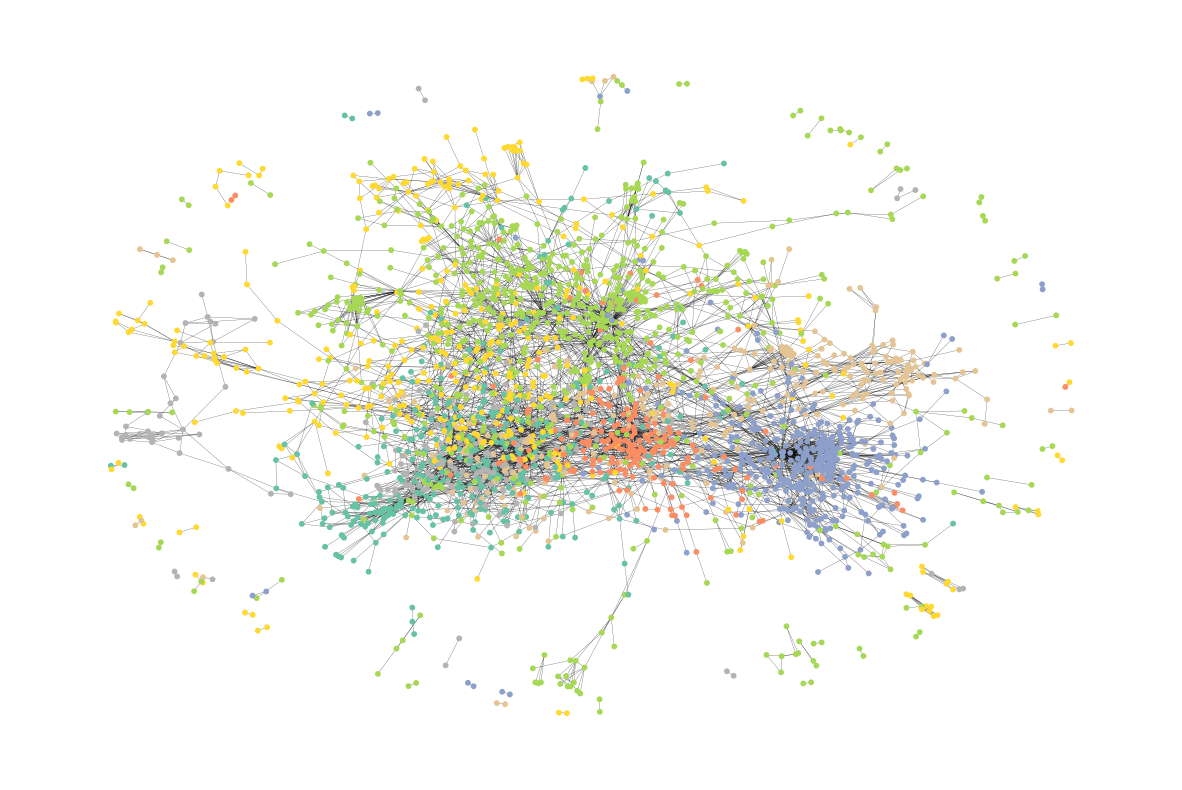

In [6]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Este dataset empieza a ser lo suficientemente grande como para que con una visualización estática como la ofrecida por Networkx sea insuficiente para apreciarlo bien. Para visualizarlo completamente, es mejor exportar el grafo y visualizarlo en una herramienta externa como [yEd Live](https://www.yworks.com/yed-live/) o [Gephi](https://gephi.org). Aquí exportamos el grafo en formato `graphml` el cual podemos usar para importarlo en las herramientas mencionadas.

También se puede intentar visualizar con librerías interactivas como [pyvis](https://pyvis.readthedocs.io/en/latest/). Pero esto está por fuera el alcance de este notebook.

## Definición de modelo GNN simple (Vanilla)

Como es costumbre, definirémos primero una red GNN simple como la del notebook anterior para efectos comparativos.

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch_geometric.data.lightning import LightningNodeData
from torchmetrics import Accuracy

from torch_geometric.utils import to_dense_adj


class VanillaGNNLayer(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(VanillaGNNLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out)
    
    def forward(self, x: torch.Tensor, adjacency: torch.Tensor) -> torch.Tensor:
        # Parte lineal de la capa, esto es XW^T
        x = self.linear(x)
        # Parte de la matriz de adyacencia, esto es A(XW^T)
        x = torch.sparse.mm(adjacency, x)
        return x
    

class VanillaGNN(LightningModule):

    def __init__(self, input_size: int, h_size: int, output_size: int):
        super(VanillaGNN, self).__init__()
        # Definimos las capas de la red.
        # Nótese que la capa GNN espera dos tensores de entrada, x y adjacency
        # Mientras que las capas ReLU y LogSoftmax solo esperan uno, x
        # Debemos tener en cuenta esto al momento de invocarlas.
        self.layers = nn.ModuleList(
            [
                VanillaGNNLayer(input_size, h_size),
                nn.ReLU(),
                VanillaGNNLayer(h_size, output_size),
                nn.LogSoftmax(dim=1)
            ]
        )

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['layers'] = str(self.layers)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, adjacency: torch.Tensor) -> torch.Tensor:
        # Ya no podemos invocar a las capas de forma secuencial
        # porque el numero de argumentos cambia entre ellas.
        # Entonces ahora las invocaremos por separado, pasando los argumentos
        # que cada capa espera.
        for i in range(len(self.layers)):
            if i % 2 == 0:
                x = self.layers[i](x, adjacency)
            else:
                x = self.layers[i](x)
        return x
    

    def get_adjacency_matrix(self, batch) -> torch.Tensor:
        # Dado que tenemos una lista de conexiones,
        # debemos obtener la matriz de adjacencia a partir de estos.
        adjacency = to_dense_adj(batch.edge_index)[0]
        adjacency += torch.eye(len(adjacency)).to(adjacency)
        return adjacency
    
    
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        # Debemos obtener la matriz ade adjacencia por cada training_step
        # debido a que entrenamos en baches, entonces la cantidad de nodos
        # y conexiones varia entre paso y paso.
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

vanilla_gnn_model = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='VanillaGNN')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(vanilla_gnn_model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/VanillaGNN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | layers    | ModuleList         | 23.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s, v_num=0, val-acc=0.746, train-loss=0.0587, train-acc=0.993]


De entrada vemos que hay una mejoría en el conjunto de validación, hemos pasado del $\sim50\%$ al $\sim70\%$, una nada despreciable mejora del $\sim20\%$. Ahora veamos como se comporta en el conjunto de prueba.

In [8]:
vanilla_gnn_model.eval()
result = trainer.test(vanilla_gnn_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7689999938011169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Definición de una GCN

Ahora procedemos con la definición de la GCN. Para esta ocasión, vamos a hacer uso directamente de las implementaciones de las capas de Pytorch Geometric.

Recordemos que a nivel general, una convolución de grafos se define como:

$$
H = \tilde{D}^{-\frac{1}{2}}\tilde{A}^T\tilde{D}^{-\frac{1}{2}}XW^T
$$

Donde:
- $H$ es la nueva representación del embedding de TODO el grafo.
- $\tilde{D}^{-\frac{1}{2}}$ Sería la inversa de la matriz de grado del grafo, junto con una matriz identidad para las autoconexiones, es decir $\tilde{D}=D+I$
- $\tilde{A}$ Es la matriz de adyacencia con autoconexiones, es decir $\tilde{A}=A+I$
- $X$ Es la representación actual del grafo en un espacio deterinado
- y $W$ son parámetros entrenables, que en esencia proyectarán el vector de los features de los nodos de un espacio orignal $N$, en un espacio más denso $D$

La formula del embedding ya está implementada internamente por la librería, lo cual nos facilita el trabajo ;)

Vamos a implementar un modelo que soporta dos tipos de capas convolucionales, una de ellas es la que mencionamos, y la otra es `SAGEConv` introducida en el paper [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216) y que está definida como (para un nodo):

$$
X_i^\prime = W_1x_i + W_2 \cdot \text{mean}_{j\in N(i)}X_j
$$

Donde:
- $W_1$ serán los parámetros entrenables aplicados al embedding del nodo $i$
- $W_2$ serán los parámetros entrenables aplicados a la agregación del vecindaro de $i$

Y cuando activamos la proyección de la capa, computarémos una capa lineal adicional sobre los nodos $j$, vecinos de $i$:

$$
X_j \leftarrow \sigma(W_3 x_j + b)
$$

Donde $W_3$ sería otra matríz de parámetros entrenables aplicados al vecindario de $i$ antes de ser agregados.


In [19]:
from torch_geometric.nn import GCNConv, SAGEConv


class GCN(LightningModule):

    def __init__(self, input_size: int, h_size: int, output_size: int, use_sage: bool = False):
        super(GCN, self).__init__()
        self.gcn1 = SAGEConv(input_size, h_size, project=True, normalize=True) if use_sage else GCNConv(input_size, h_size)
        self.gcn2 = SAGEConv(h_size, output_size, project=True, normalize=True) if use_sage else GCNConv(h_size, output_size)

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['gcn1'] = str(self.gcn1)
        self.hparams['gcn2'] = str(self.gcn2)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, edge_index) -> torch.Tensor:
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

gcn_model = GCN(dataset.num_features, 16, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='GCN')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(gcn_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | gcn1      | GCNConv            | 22.9 K
1 | gcn2      | GCNConv            | 119   
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 16.20it/s, v_num=1, val-acc=0.784, train-loss=0.0106, train-acc=1.000] 


In [20]:
gcn_model.eval()
result = trainer.test(gcn_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7979999780654907
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [21]:
sage_gcn_model = GCN(dataset.num_features, 16, dataset.num_classes, use_sage=True)
tb_logger = TensorBoardLogger('tb_logs', name='SageGCN')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(sage_gcn_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | gcn1      | SAGEConv           | 2.1 M 
1 | gcn2      | SAGEConv           | 503   
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.405     Total estimated model params size (MB)


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s, v_num=1, val-acc=0.694, train-loss=1.110, train-acc=1.000]


In [22]:
sage_gcn_model.eval()
result = trainer.test(sage_gcn_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7110000252723694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


En este caso, la diferencia que encontramos entre el modelo sencillo y las capas que implementa pytorch geometric no es tan significativo comparado con el modelo MLP sencillo, aunque si ligeramente mejor. Incluso, dependiendo de la capa convolucional seleccionada, podría no ser tan efectiva. Valdría la pena experimentar con las otras capas convolucionales: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers

### Observando el proceso de entrenamiento

In [23]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 1769446), started 0:12:48 ago. (Use '!kill 1769446' to kill it.)

En cuanto al proceso de entrenamiento, los tres modelos tienen curvas de aprendizaje similares. Algo para observar y debatir es que el modelo VanillaGNN sigue convergiendo más rápido que los demás, 22 pasos, sin embargo, el modelo GCN alcanza una mejor tasa de correctitud en el conjunto de validación. Incluso, en un punto, el modelo SAGEConv fue superior al los otros dos. Pueden haber múltiples factores para esta situación, es recomendable experimentar con los hiper-parámetros (hacer hyper-parameter tuning).

### Haciendo predicciones

In [15]:
test_indices = data.test_mask.nonzero(as_tuple=False).squeeze()
test_nodes = data.x
test_edges = data.edge_index[:, test_indices.tolist()].T.tolist()
test_y = data.y[data.test_mask]

In [16]:
def build_output_graph(data, targets):
    graph = nx.Graph()
    for source, target in data.edge_index.T.tolist():
        if data.test_mask[source] and data.test_mask[target]:
            graph.add_edge(source, target)

    classes = []
    for node in graph.nodes:
        classes.append(targets[node])

    return graph, classes

In [17]:
# Ground Truth
test_graph, test_classes = build_output_graph(data, data.y)


# Predicciones Vanilla GNN
adjacency = vanilla_gnn_model.get_adjacency_matrix(data)
vgnn_pred = vanilla_gnn_model(data.x, adjacency)
vgnn_pred = vgnn_pred[data.test_mask]
vgnn_pred = torch.argmax(vgnn_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), vgnn_pred.tolist()))
vgnn_graph, vgnn_preds = build_output_graph(data, node_preds)

# Predicciones GCN
gcn_pred = gcn_model(data.x, data.edge_index)
gcn_pred = gcn_pred[data.test_mask]
gcn_pred = torch.argmax(gcn_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), gcn_pred.tolist()))
gcn_graph, gcn_preds = build_output_graph(data, node_preds)

# Predicciones SAGEConv
sage_pred = sage_gcn_model(data.x, data.edge_index)
sage_pred = sage_pred[data.test_mask]
sage_pred = torch.argmax(sage_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), sage_pred.tolist()))
sage_graph, sage_preds = build_output_graph(data, node_preds)

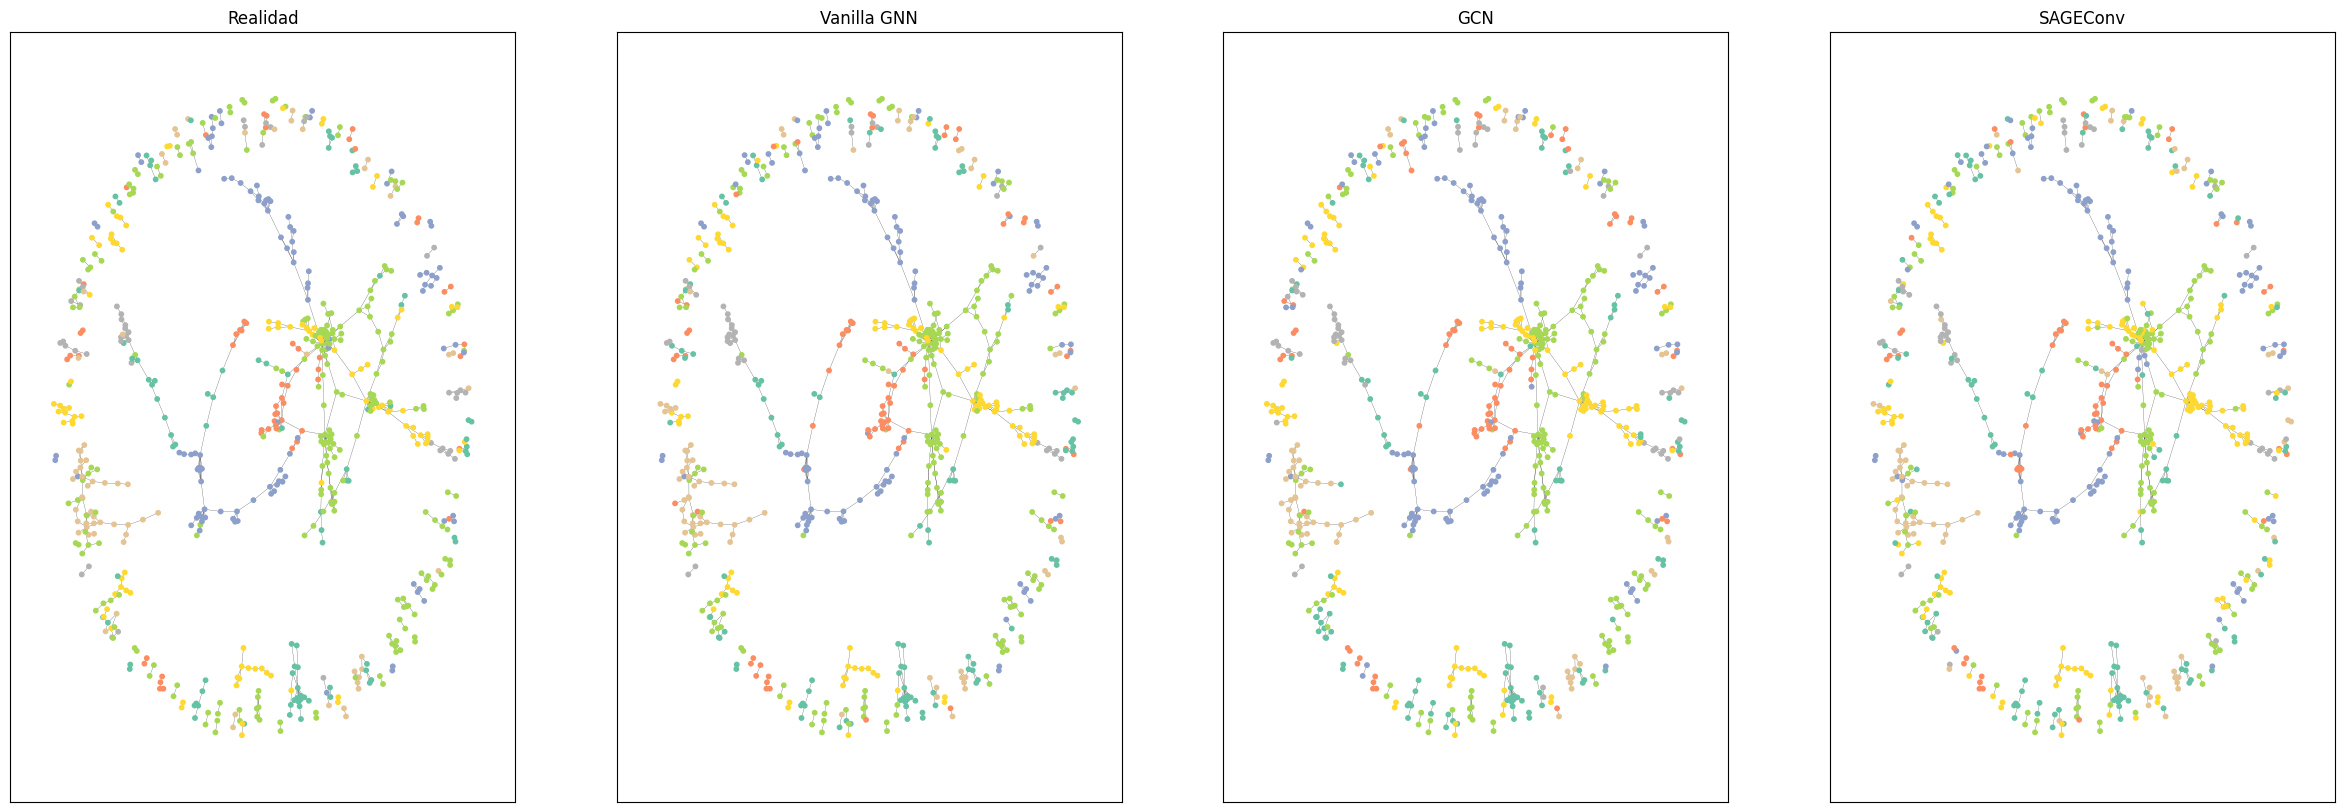

In [18]:
visualize_graphs(
    {
        'Realidad': dict(graph=test_graph, classes=test_classes), 
        'Vanilla GNN': dict(graph=vgnn_graph, classes=vgnn_preds),
        'GCN': dict(graph=gcn_graph, classes=gcn_preds),
        'SAGEConv': dict(graph=sage_graph, classes=sage_preds),
        }
)

## Conclusiones

| Vanilla GNN | GCN | SAGEConv |
|-------------|-----|----------|
|~76%         |~79% (+- 2) |~71% (+- 5)     |

- Dados los resultados, inicialmente podemos concluir que las convoluciones grafales ofrecen un ligero empuje en la tasa de correctitud para la tarea.
- Las capas `SAGEConv` por otro lado, para este caso particular tienden a sufrir de mayor varianza en los resultados, lo cual podría sugerir que hace falta regularización.
- En todos los casos explorados, se trabajó con modelos simples, de solo dos capas de GNN, incrementar la complejidad del modelo y probar diferentes combinaciones de hiper-parámetros podría ayudar a mejorar la calidad del modelo.